In [1]:
%matplotlib inline

# Omori law statistics

The modified Omori law (*Utsu, 1961*) describes the power-law decay of aftershock rates following a mainshock with magnitude $M_m$:

$$N(t,M \geq M_c) = K(t+c)^{-p}$$

- $N$ : cumulative number of aftershocks
- $t$ : elapsed time since mainshock
- $M_c$: completeness magnitude
- $K$ : productivity (initial slope), depends on $M_m$ and $M_c$
- $p$ : power-law exponent, independent of $M_m$ and $M_c$ (0.6 - 2.5 according to worldwide survey, with median ~1.1)
- $c$ : small positive constant, interpreted as delay of earliest part of the sequence (0.01 - 1 days)

Based on the following papers:
- Utsu, T., Ogata, Y., Matsu'ura, R. (1995), "The Centenary of the Omori Formula for a Decay Law of Aftershock Activity", *J. Phys. Earth*, **43**, 1-33 (https://www.jstage.jst.go.jp/article/jpe1952/43/1/43_1_1/_pdf)

In [2]:
import pylab
import numpy as np
import mapping.layeredbasemap as lbm
import eqcatalog
import hazard.rshalib as rshalib

OpenQuake version: 3.8.1


Read earthquake sequence from database

In [3]:
cat = eqcatalog.rob.query_local_eq_catalog(start_date='2021-01-01', region=(6.0, 6.3, 50.58, 50.875))
cat.print_info()

+-------------------+-------------------------------------------------------+
|     Parameter     |                         Value                         |
+-------------------+-------------------------------------------------------+
|    Catalog name   | ROB Catalog 2021-01-01T00:00:00 - 2021-01-18T16:52:10 |
| Earthquake number |                           50                          |
|     Start time    |                2021-01-01T00:00:00.000                |
|      End time     |                2021-01-18T16:52:10.000                |
|  Longitude bounds |                    6.0972 / 6.2433                    |
|  Latitude bounds  |                   50.5898 / 50.8522                   |
|    Depth range    |                     8.5 / 15.8 km                     |
|         ML        |                n=50, min=-1.4, max=2.6                |
|    Event types    |                       ke (n=50)                       |
+-------------------+-------------------------------------------

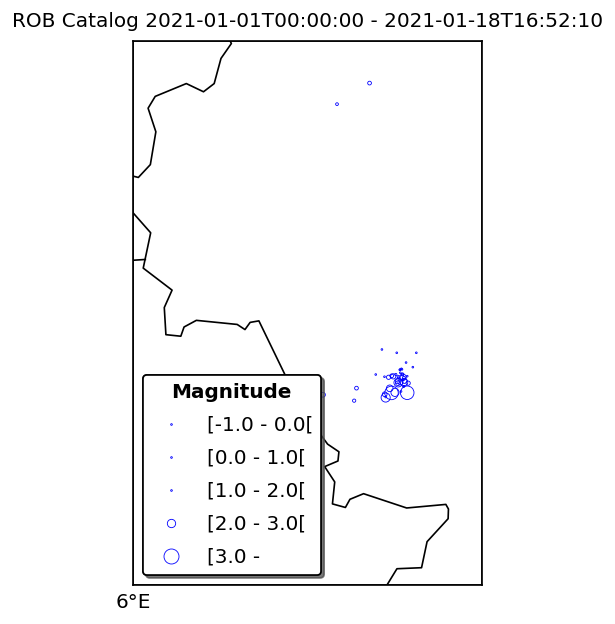

In [4]:
cat.plot_map(resolution='h')

### Declustering analysis

Check if different declustering windows/methods identify sequence as 1 cluster. Note that all declustering methods are based on $M_W$, so we need a conversion from $M_L$.

In [5]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()

In [6]:
Mrelation = {'ML': 'GruenthalEtAl2009'}
for dc_window_name in ('GardnerKnopoff1974', 'Uhrhammer1986', 'Gruenthal2009'):
    print(dc_window_name)
    dc_window = eqcatalog.declustering.get_window_by_name(dc_window_name)
    dc_result = dc_method.analyze_clusters(cat, dc_window, Mrelation)
    dc_result.print_info()
    print()

GardnerKnopoff1974
Number of clusters identified: 2
Max. cluster length: 34
Num. clustered/unclustered events: 49 / 1
Num. dependent/independent events: 47 / 3

Uhrhammer1986
Number of clusters identified: 4
Max. cluster length: 14
Num. clustered/unclustered events: 21 / 29
Num. dependent/independent events: 17 / 33

Gruenthal2009
Number of clusters identified: 1
Max. cluster length: 50
Num. clustered/unclustered events: 50 / 0
Num. dependent/independent events: 49 / 1



In [7]:
dc_method = eqcatalog.declustering.ReasenbergMethod()
dc_window = eqcatalog.declustering.Reasenberg1985Window(dsigma=30, xmeff=0.7)
dc_result = dc_method.analyze_clusters(cat, Mrelation, dc_window, ignore_location_errors=False)
print('Reasenberg1985')
dc_result.print_info()

Reasenberg1985
Number of clusters identified: 1
Max. cluster length: 47
Num. clustered/unclustered events: 47 / 3
Num. dependent/independent events: 46 / 4


In [8]:
dc_result.get_unclustered_events().print_list()

+-------+------------+-----------------+--------------+-------+--------+------+------+
|    ID |    Date    |       Time      |     Name     |   Lon |    Lat |    Z |   ML |
+-------+------------+-----------------+--------------+-------+--------+------+------+
| 11740 | 2021-01-02 | 21:13:12.490000 |  ROTT (DE)   | 6.143 | 50.590 | 11.1 | -1.4 |
| 11665 | 2021-01-03 | 07:05:10.270000 | ALSDORF (DE) | 6.203 | 50.852 | 15.8 |  0.6 |
| 11685 | 2021-01-03 | 10:50:45.320000 | ALSDORF (DE) | 6.175 | 50.841 | 15.4 |  0.4 |
+-------+------------+-----------------+--------------+-------+--------+------+------+


### Omori-law fitting

Determine completeness magnitude Mc

Number of events constrained by completeness criteria: 33 out of 50


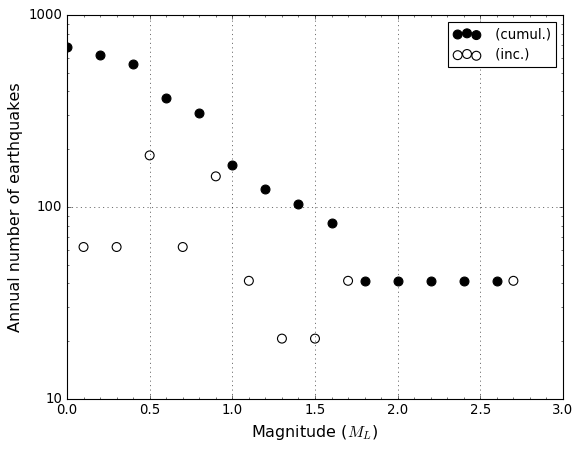

In [9]:
completeness = cat.get_uniform_completeness(0, Mtype='ML')
seq_mfd = cat.get_incremental_mfd(0, 3, 0.2, Mtype='ML', completeness=completeness)
seq_mfd.plot()

Mc can be estimated as 0.7 (0.3 if you are optimistic)

In [10]:
Mc = 0.3
#Mc = 0.7

Estimate parameters K, c, p of Omori law based on elapsed times since mainshock

In [11]:
mainshock = cat.get_event_by_id(11630)
Mm = mainshock.ML
mainshock.print_info()

+------------+-----------------+
| Attribute  |      Value      |
+------------+-----------------+
|     ID     |      11630      |
|    name    |    ROTT (DE)    |
|    date    |    2021-01-02   |
|    time    | 06:36:29.430000 |
|    lon     |      6.2355     |
|    lat     |     50.6843     |
|   depth    |       11.3      |
|     ML     |       2.6       |
|    errt    |       0.33      |
|    errh    |       0.5       |
|    errz    |       0.57      |
|    errM    |       0.2       |
|   agency   |       ROB       |
| event_type |        ke       |
+------------+-----------------+


In [12]:
cluster = dc_result.get_cluster_by_eq(mainshock)
aftershocks = cluster.get_aftershocks()
aftershocks.print_info()

+-------------------+--------------------------+
|     Parameter     |          Value           |
+-------------------+--------------------------+
|    Catalog name   | Cluster #0 (aftershocks) |
| Earthquake number |            42            |
|     Start time    | 2021-01-02T07:31:02.060  |
|      End time     | 2021-01-17T20:14:21.230  |
|  Longitude bounds |     6.0972 / 6.2433      |
|  Latitude bounds  |    50.6685 / 50.7078     |
|    Depth range    |      8.5 / 14.1 km       |
|         ML        | n=42, min=-0.9, max=2.6  |
|    Event types    |        ke (n=42)         |
+-------------------+--------------------------+


In [13]:
cc_aftershocks = aftershocks.subselect(Mmin=Mc, Mtype='ML')
print(len(cc_aftershocks))

24


Number of events constrained by completeness criteria: 24 out of 24
Number of events constrained by completeness criteria: 24 out of 24
<TruncatedGRMFD | ML=0.70:2.60:0.10 | a=3.15, b=0.86>


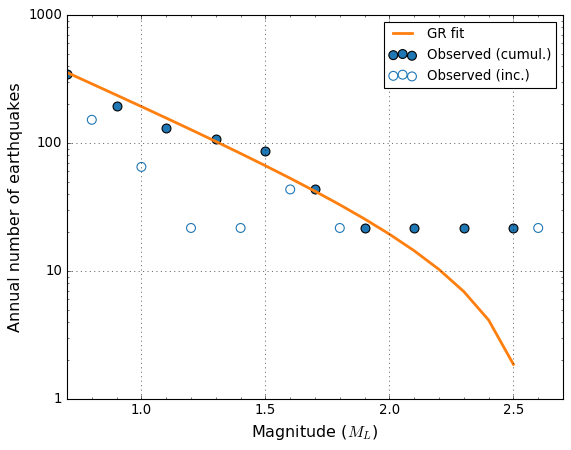

In [14]:
as_imfd = cc_aftershocks.get_incremental_mfd(0.7, Mm, Mtype='ML', completeness=completeness)
as_tmfd = cc_aftershocks.get_estimated_mfd(0.7, Mm, Mtype='ML', completeness=completeness)
print(as_tmfd)
rshalib.mfd.plot_mfds([as_imfd, as_tmfd], labels=['Observed', 'GR fit'])

In [15]:
as_time_deltas = cc_aftershocks.get_time_deltas(mainshock.datetime)
as_time_deltas = eqcatalog.time.fractional_time_delta(as_time_deltas, 'D')
as_time_deltas

array([  0.29376157,   0.33158565,   0.34032407,   0.34800926,
         0.75746528,   0.83662037,   0.96208333,   0.97803241,
         1.97284722,   2.91003472,   3.90126157,   4.195625  ,
         4.5047338 ,   5.84746528,   8.17983796,  11.75318287,
        12.47912037,  12.48949074,  12.5724537 ,  13.00178241,
        13.44228009,  14.49819444,  14.89883102,  14.93494213])

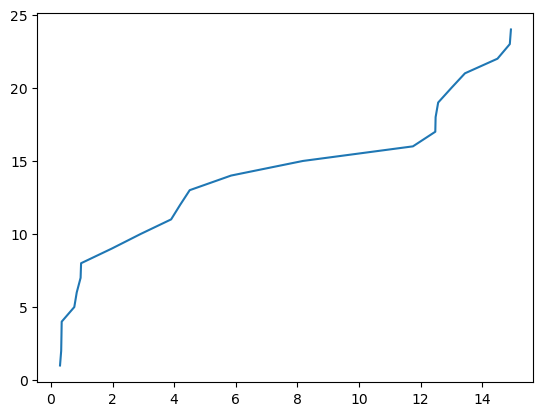

In [16]:
pylab.plot(as_time_deltas, np.arange(len(cc_aftershocks))+1)

Fit full sequence

In [17]:
(K1, c1, p1) = eqcatalog.omori.estimate_omori_params(as_time_deltas)
print(K1, c1, p1)

3.28576459636 0.161764157741 0.462523904464


C:\Miniconda3\envs\py3\lib\site-packages\scipy\optimize\_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Fit first 12 days

In [18]:
(K2, c2, p2) = eqcatalog.omori.estimate_omori_params(as_time_deltas[as_time_deltas < 12])
print(K2, c2, p2)

10.6047285803 1.15112659109 1.37433780908


Note that value of K depends on completeness magnitude and mainshock magnitude, so these are inherent properties of the Omori law!

Define Omori law, including completeness magnitude and mainshock magnitude. Default time unit is days.

In [19]:
omlaw1 = eqcatalog.omori.OmoriLaw(K1, c1, p1, Mc, Mm)
omlaw2 = eqcatalog.omori.OmoriLaw(K2, c2, p2, Mc, Mm)

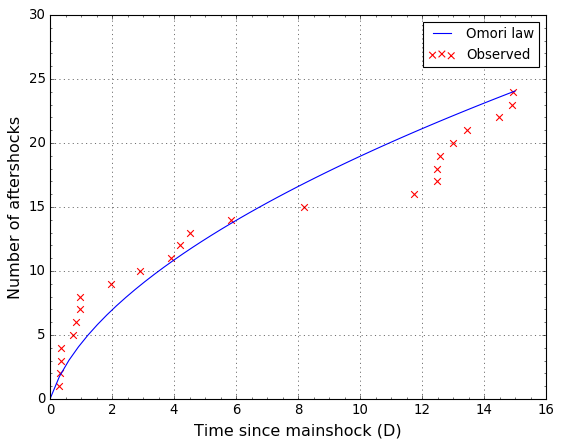

In [20]:
num_days = 15
x_values = np.linspace(0, num_days, 50)
omlaw1.plot_cumulative(x_values, observed_delta_t=as_time_deltas, xscaling='lin')

In [21]:
cc_aftershocks[[4,10,16]].print_list()

+-------+------------+-----------------+-----------+-------+--------+------+-----+
|    ID |    Date    |       Time      |    Name   |   Lon |    Lat |    Z |  ML |
+-------+------------+-----------------+-----------+-------+--------+------+-----+
| 11680 | 2021-01-03 | 00:47:14.830000 | ROTT (DE) | 6.231 | 50.694 |  9.5 | 0.4 |
| 11770 | 2021-01-06 | 04:14:19.200000 | ROTT (DE) | 6.232 | 50.693 | 10.8 | 1.1 |
| 11880 | 2021-01-14 | 18:06:26.070000 | ROTT (DE) | 6.222 | 50.684 |  9.8 | 2.6 |
+-------+------------+-----------------+-----------+-------+--------+------+-----+


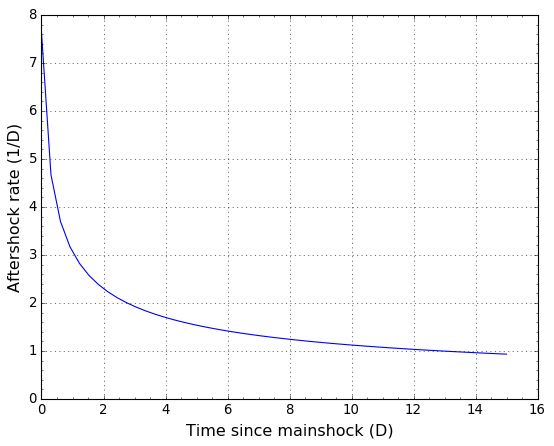

In [22]:
omlaw1.plot_rate(x_values)

### Probabilities and predictions

Assuming aftershock occurrence follows a **Poisson** probability model (see separate notebook), it is possible to compute probabilities and make some predictions. All predictions are valid for $M \geq Mc$

Number of aftershocks

In [23]:
end_time = 15
omlaw1.get_num_aftershocks(end_time)

24.06084753106671

In [24]:
start_time = 10
end_time = 15
omlaw1.get_num_aftershocks(end_time, start_time)

5.100508326617707

Probability of exactly $n$ earthquakes

In [25]:
n = 1
start_time = 5
end_time = 6
omlaw1.get_prob_n_aftershocks(n, end_time, start_time)

0.33745998907593738

Probability of $\geq 1$ earthquakes

In [26]:
start_time = 5
end_time = 6
omlaw1.get_prob_one_or_more_aftershocks(end_time, start_time)

0.77119734045798283

Duration

In [27]:
n = 15
omlaw1.get_time_delta_for_n_aftershocks(n)

6.762521731310169

In [33]:
omlaw1.get_time_delta_for_n_aftershocks(n, delta_t1=5)

18.855043661108585

To compute aftershock duration, we need to know the background rate. We estimate this from the entire catalog since 1985, convert to daily rate, and correct for area

In [79]:
full_cat = eqcatalog.read_named_catalog('ROB', verbose=False).subselect(start_date=1985)
full_cat.print_info()

+-------------------+-------------------------------------------------------------------+
|     Parameter     |                               Value                               |
+-------------------+-------------------------------------------------------------------+
|    Catalog name   | ROB Catalog 1350-01-01T00:00:00 - 2021-01-18T16:34:21 (subselect) |
| Earthquake number |                                2234                               |
|     Start time    |                      1985-01-01T00:00:00.000                      |
|      End time     |                      2021-01-18T16:34:21.000                      |
|  Longitude bounds |                          1.1700 / 8.0000                          |
|  Latitude bounds  |                         49.1630 / 51.9500                         |
|    Depth range    |                           0.0 / 42.6 km                           |
|         ML        |                     n=2196, min=-1.4, max=5.8                     |
|         

Determine Gutenberg-Richter relation for entire catalog. Note that b-value is very similar to that of the aftershock sequence!

Number of events constrained by completeness criteria: 2113 out of 2234
Number of events constrained by completeness criteria: 2113 out of 2234
<TruncatedGRMFD | ML=0.30:5.00:0.20 | a=2.51, b=0.78>


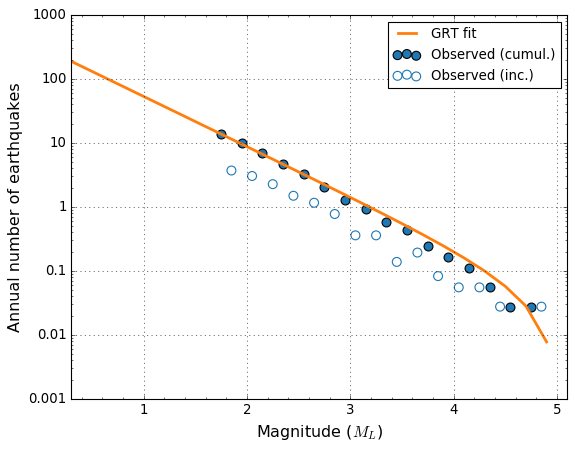

In [80]:
completeness = full_cat.get_uniform_completeness(0, Mtype='ML')
cat_imfd = full_cat.get_incremental_mfd(1.75, 5, 0.2, Mtype='ML', completeness=completeness)
cat_tmfd = full_cat.get_estimated_mfd(1.75, 5, 0.2, Mtype='ML', completeness=completeness)
cat_tmfd.min_mag = Mc
print(cat_tmfd)
rshalib.mfd.plot_mfds([cat_imfd, cat_tmfd], labels=['Observed', 'GRT fit'])

In [81]:
area_factor = (lbm.PolygonData.from_bbox(full_cat.get_region()).get_area()
               / lbm.PolygonData.from_bbox(cat.get_region()).get_area())
print(area_factor)

494.98433809778857


In [82]:
background_rate = cat_tmfd.get_cumulative_rates()[0]
background_rate /= 365
background_rate /= area_factor
print(background_rate)

0.00104499622342


In [83]:
#background_rate = 1./30
omlaw1.get_aftershock_duration(background_rate)

36460137.148645721

We can do some predictions, but not about the magnitude distribution!

In order to do that, we need to combine the Omori law with the Gutenberg-Richter relation (*Reasenberg & Jones, 1989, 1994*). This involves converting K to the magnitude-independent productivity parameter $A$, which is thought to be characteristic of a region:

$$A = \log_{10}(K) - b (M_m - M_c)$$

where $b$ is the b-value of the Gutenberg-Richter relation (log10 notation)

Note that it would be better to convert ML to MW for this exercise

In [84]:
b_value = as_tmfd.b_val
gr_omlaw = omlaw1.to_gr_omori_law(b_value)

In [85]:
gr_omlaw.K

3.2857645963642854

Now we can compute probabilities for higher Mc, simply by changing the Mc property of the Base10GROmoriLaw instance

In [86]:
gr_omlaw.Mc = 4
gr_omlaw.K

0.0022113543205194248

In [87]:
start_time = 13
end_time = start_time + 30
gr_omlaw.get_prob_one_or_more_aftershocks(end_time, start_time)

0.014578797478304373

Let's compare this to the background probability, derived from the catalog MFD

In [88]:
tau = cat_tmfd.get_return_periods()[cat_tmfd.get_magnitude_index(4)]
tau *= 365
print(tau)

3510.57483577


In [89]:
poisson_tau = rshalib.poisson.PoissonTau(tau)
poisson_tau.get_prob_one_or_more(30)

0.0085091990971688514

In the area of the Rott sequence:

In [90]:
poisson_tau.tau *= area_factor
poisson_tau.get_prob_one_or_more(30)

1.7264253836746235e-05

So the sequence has indeed increased the probability of larger earthquakes (but this probability will decrease again over time)!

What is the probability of an earthquake with $M_L \geq 2.6$ (mainshock magnitude) based on the first 12 days?

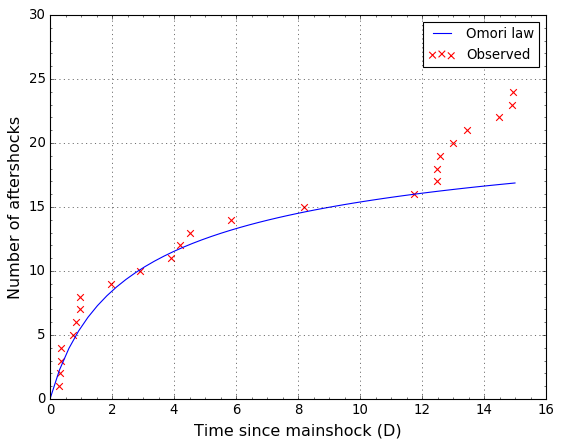

In [91]:
gr_omlaw2 = omlaw2.to_gr_omori_law(b_value)
gr_omlaw2.plot_cumulative(x_values, observed_delta_t=as_time_deltas, xscaling='lin')

In [92]:
gr_omlaw2.Mc = Mm
start_time = 12
end_time = start_time + 30
gr_omlaw2.get_prob_one_or_more_aftershocks(end_time, start_time)

0.040530798695844861

### Random simulation

We can also simulate aftershock sequences or their properties

In [93]:
start_time = 13
end_time = start_time + 30
num_samples = 100
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
gr_omlaw.Mc = 2
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 3, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1,
       0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 3, 1, 0, 2, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 2, 1,
       1, 0, 1, 2, 1, 2, 0, 1])

In [95]:
duration = 100
gr_omlaw.get_random_time_deltas(duration)

array([  9.64109015,  16.50405598,  18.59782134,  20.31827491])

In [96]:
num_samples = 20
gr_omlaw.get_random_magnitudes(num_samples)

array([ 2.04748978,  2.32606715,  2.16515542,  2.53814751,  2.12177988,
        2.00945351,  2.35844926,  2.1140137 ,  2.28850709,  2.46660684,
        2.39197684,  2.13098809,  2.16016666,  2.06781723,  2.31866112,
        2.5918603 ,  2.09107647,  2.00280052,  2.05273811,  2.19959413])

In [97]:
duration = 100
Mmax = 6.0
for event in gr_omlaw.gen_aftershock_sequence(duration, etas=True, Mmax=Mmax):
    (delta_time, magnitude, index, parent_index) = event
    print('dt=%.2f days, M=%.2f, i=%d, parent=%d' % event)

dt=2.59 days, M=2.59, i=1, parent=0
dt=8.04 days, M=2.51, i=2, parent=0
dt=22.08 days, M=2.23, i=3, parent=0
dt=18.42 days, M=2.11, i=4, parent=1
dt=56.46 days, M=2.05, i=5, parent=1
dt=95.09 days, M=2.58, i=6, parent=1
dt=15.62 days, M=2.01, i=7, parent=2
dt=30.88 days, M=2.05, i=8, parent=2
dt=39.63 days, M=2.16, i=9, parent=2
dt=42.59 days, M=2.35, i=10, parent=2
dt=50.05 days, M=2.10, i=11, parent=2
dt=45.11 days, M=2.06, i=12, parent=3
dt=68.31 days, M=2.07, i=13, parent=4
dt=20.53 days, M=2.00, i=14, parent=7
dt=70.37 days, M=2.14, i=15, parent=9
dt=71.45 days, M=2.01, i=16, parent=9
dt=72.67 days, M=2.01, i=17, parent=9
dt=55.63 days, M=2.05, i=18, parent=12
dt=56.78 days, M=2.03, i=19, parent=12
dt=93.77 days, M=2.04, i=20, parent=12
dt=21.65 days, M=2.00, i=21, parent=14
dt=71.91 days, M=2.08, i=22, parent=15
dt=78.25 days, M=2.01, i=23, parent=16
dt=22.83 days, M=2.00, i=24, parent=21
dt=52.26 days, M=2.00, i=25, parent=21
dt=54.47 days, M=2.00, i=26, parent=21
dt=85.32 days,

In [98]:
gr_omlaw.Mc = 0.7
syncat = gr_omlaw.gen_aftershock_catalog(duration, mainshock=mainshock, etas=False, Mmax=Mmax)
syncat.print_list()

+----+------------+-----------------+--------------------+-------+--------+------+-----+
| ID |    Date    |       Time      |        Name        |   Lon |    Lat |    Z |  MW |
+----+------------+-----------------+--------------------+-------+--------+------+-----+
|  1 | 2021-01-03 | 02:58:31.786000 | AS #1 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.0 |
|  2 | 2021-01-04 | 14:58:43.708000 | AS #2 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.0 |
|  3 | 2021-01-04 | 16:31:13.874000 | AS #3 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.4 |
|  4 | 2021-01-05 | 02:50:51.313000 | AS #4 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.0 |
|  5 | 2021-01-05 | 05:04:39.548000 | AS #5 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.4 |
|  6 | 2021-01-07 | 08:27:48.347000 | AS #6 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.3 |
|  7 | 2021-01-09 | 10:35:14.364000 | AS #7 (parent: 0)  | 6.236 | 50.684 | 11.3 | 1.7 |
|  8 | 2021-01-09 | 11:30:24.883000 | AS #8 (parent: 0)  | 6.236 | 50.684 | 11.3 | 0.8 |
|  9 | 2021-01-13 | 1